In [1]:
from os import listdir,path
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import cv2
cv2.__version__

from scipy.stats import norm
from scipy.ndimage import maximum_filter, minimum_filter
from scipy.ndimage.morphology import binary_fill_holes

In [2]:
from dicomUtils import *
sample_dir = '../data/PACS/Larry_Smarr_2016/series_23_Cor_LAVA_PRE-Amira/'
sample_single_dir = 'test/sample_single'

In [3]:
def imshow_single(img, title):
    fig,ax = plt.subplots()
    ax.imshow(img,cmap='gray')
    ax.set_title(title)
def imshow_double(img1, img2, title):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(img1,cmap='gray')
    ax2.imshow(img2,cmap='gray')
    fig.suptitle(title, fontsize=16)

In [4]:
sv = getVolume(sample_dir)
volume_data = sv.raw_data
volume_data.shape

(512, 512, 144)

In [5]:
img_12bit = volume_data[:,:,70]
img_12bit = img_12bit.astype(np.uint16)

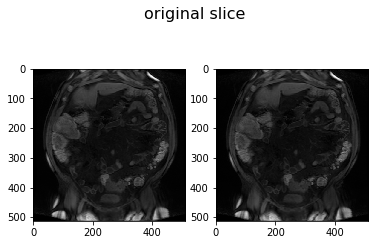

In [6]:
img_8bit = img_12bit * 0.06227106227106227
ori_img = img_8bit.astype(np.uint8)
imshow_double(img_12bit,ori_img, "original slice")

In [22]:
np.max(ori_img)

205

In [30]:
from scipy.signal import convolve2d as conv2
from skimage.filters import threshold_otsu
from skimage.morphology import convex_hull_image
from skimage import exposure as ex
from skimage.filters import median
from skimage.morphology import square
from skimage.util import pad

def foregroundBackground(mask,originalImage):
    [row,col] = np.shape(mask)
    fg = np.abs(mask*originalImage)
    fg = np.copy(fg)
    bg = originalImage
    bg = np.copy(bg)
    for i in range(row):
        for j in range(col):
                if(mask[i,j]==1):
                    bg[i,j]=255
                if(mask[i,j]==0):
                    fg[i,j]=255
    return (fg,bg)

def foregroundAndConvex(img):
    try:
        h = ex.equalize_hist(img)
        oi = np.zeros_like(img, dtype=np.uint16)
        oi[(img > threshold_otsu(img)) == True] = 1
        oh = np.zeros_like(img, dtype=np.uint16)
        oh[(h > threshold_otsu(h)) == True] = 1
        nm = img.shape[0] * img.shape[1]
        w1 = np.sum(oi)/(nm)
        w2 = np.sum(oh)/(nm)
        ots = np.zeros_like(img, dtype=np.uint16)
        new =( w1 * img) + (w2 * h)
        ots[(new > threshold_otsu(new)) == True] = 1
        conv_hull = convex_hull_image(ots)
        ch = np.multiply(conv_hull, 1)
#         fore_image = ch * img
#         back_image = (1 - ch) * img
        (fore_image, back_image) = foregroundBackground(ch, img)
    except Exception: 
        print("exception")
        fore_image = img.copy()
        back_image = np.zeros_like(img, dtype=np.uint16)
        conv_hull = np.zeros_like(img, dtype=np.uint16)
    return ch,fore_image, back_image, conv_hull, img[conv_hull], img[conv_hull==False]

207981

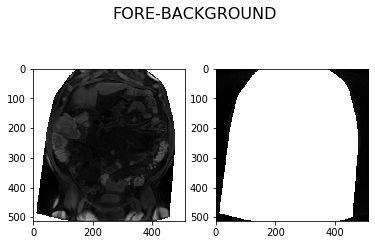

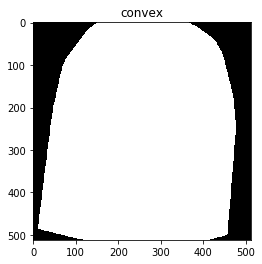

In [36]:
ch,F, B, c, f, b = foregroundAndConvex(ori_img)
imshow_double(F,B,"FORE-BACKGROUND")
imshow_single(c,"convex")


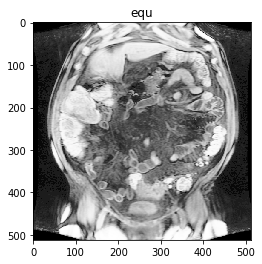

In [37]:
img = cv2.equalizeHist(ori_img)
imshow_single(img,"equ")

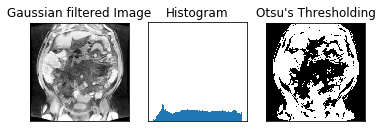

In [38]:
blur = cv2.GaussianBlur(img,(5,5),0)
ret,img_thre = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)


# ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# # # plot all the images and their histograms
images = [blur,0,img_thre]
titles = ['Gaussian filtered Image','Histogram',"Otsu's Thresholding"]
for i in range(1):
    plt.subplot(2,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(2,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(2,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

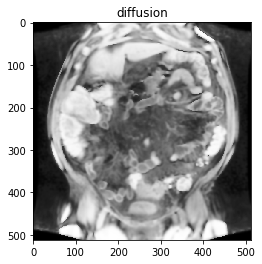

In [39]:
from util.AnDiffusion import *
# reducing image noise without removing significant parts
diffusion = anisodiff(img,20,50,0.1)
imshow_single(diffusion,"diffusion")

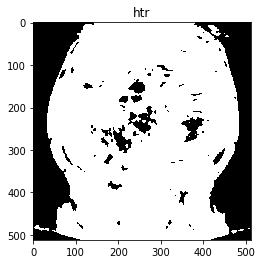

In [40]:
# normalize and edge detection
# regions where `image` is greater than `high` OR `image` is greater than `low` *and* that region is connected to
#     a region greater than `high`.
mu,sigma = norm.fit(diffusion)
htr = apply_hysteresis_threshold(diffusion,mu,sigma).astype(int)
imshow_single(htr,"htr")

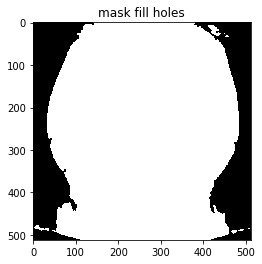

In [41]:
pmask = binary_fill_holes(htr)
imshow_single(pmask,"mask fill holes")

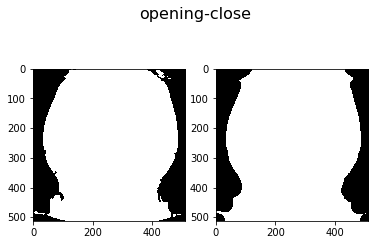

In [42]:
# erosion
pamsk_value = pmask.astype(np.uint8)
# kernel = np.ones((5,5), np.uint8)
kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
kernel2= cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (50,50))
# eroded = cv2.erode(pmask.astype(np.uint16),kernel,iterations = 5)

# opening = cv2.morphologyEx(pamsk_value, cv2.MORPH_OPEN, kernel)
ret1 = cv2.morphologyEx(pamsk_value, cv2.MORPH_CLOSE, kernel1)
ret2 = cv2.morphologyEx(pamsk_value, cv2.MORPH_CLOSE, kernel2)
# eroded = cv2.erode(pmask.astype(np.uint16),kernel,iterations = 5)

imshow_double(ret1, ret2, "opening-close")
# imshow_single(eroded,"mask eroded")

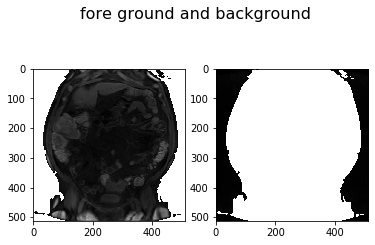

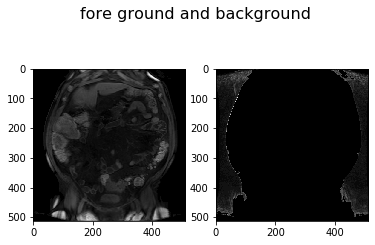

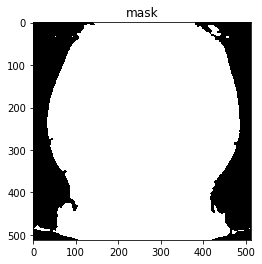

In [44]:
[fg,bg]=foregroundBackground(ret1, ori_img)
imshow_double(fg, bg,"fore ground and background")
fore_image = ret1 * ori_img
back_image = (1 - ret1) * ori_img
imshow_double(fore_image, back_image,"fore ground and background")
imshow_single(ret1, "mask")

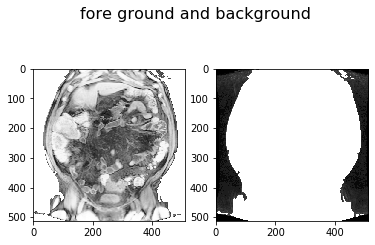

In [123]:
[fg_equ,bg_equ]=foregroundBackground(closing, img)
imshow_double(fg_equ, bg_equ,"fore ground and background")

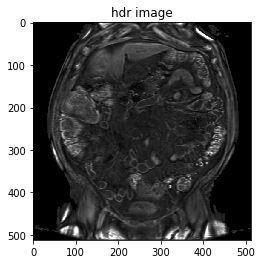

In [103]:
hdr_filter = HDRFilter()
hdr = pmask * hdr_filter.process(ori_img)
imshow_single(hdr,"hdr image")

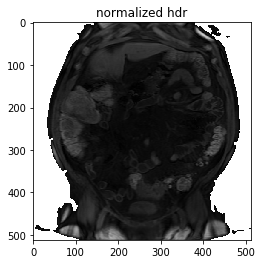

In [114]:
gray = cv2.normalize(fg, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
imshow_single(gray,"normalized hdr")

0.009045885606261815 0.040261221428906216 0.025801219475565434 0.005797014387408764


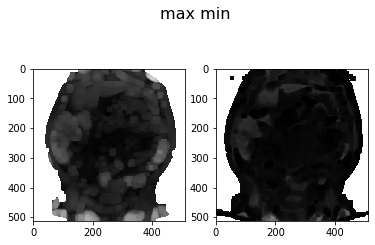

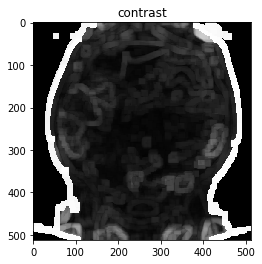

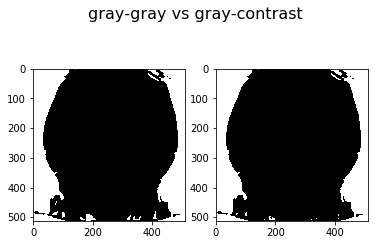

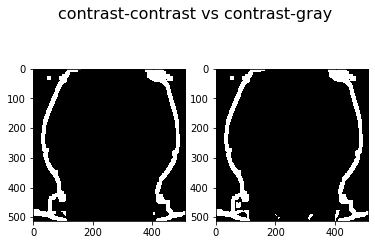

In [115]:
window = (13, 13)
# contrast feature img
maximg = maximum_filter(gray, size = window)
minimg = minimum_filter(gray, size = window)
contrast_img = maximg - minimg
imshow_double(maximg, minimg, "max min")
imshow_single(contrast_img,"contrast")
# image moment
grayscale_moment = cv2.moments(gray)['nu20']
contrast_moment = cv2.moments(contrast_img)['nu20']
# binary image
fgmg = (gray > grayscale_moment).astype(np.int)
fcmg = (gray > contrast_moment).astype(np.int)
imshow_double(fgmg, fcmg, "gray-gray vs gray-contrast")

fcmc = (contrast_img > contrast_moment).astype(np.int)
fgmc = (contrast_img > grayscale_moment).astype(np.int)
imshow_double(fcmc, fgmc,"contrast-contrast vs contrast-gray")
# luminance contrast quality score
q11 = fcmg & fgmg
q1 = np.sum(mask * q11) / max(np.sum(fcmg), np.sum(fgmg)) if max(np.sum(fcmg), np.sum(fgmg)) != 0 else 0

# texture score
q22 = fgmc & fcmc
q2 = np.sum(mask * q22) / max(np.sum(fgmc), np.sum(fgmg)) if max(np.sum(fgmc), np.sum(fgmg)) != 0 else 0

# texture contrast quality score
q33 = fgmc & fcmc
q3 = np.sum(mask * q33) / np.sum(mask) if np.sum(mask) != 0 else 0

# lightness quality score
q44 = fcmg & fgmg
q4 = np.sum(mask * q44) / np.sum(mask) if np.sum(mask) != 0 else 0
print(q1, q2, q3, q4)